In [1]:
# default_exp analyses

# Measuring the Serial Position Effect in Repetition Data
The serial position effect describes how our memory is affected by the position of information in a sequence. 
Here we extend on previous implementations to ensure recall rates are successfully measured and visualized when study lists can include two presentations of study items. 

**NOTE**: function not yet tested for lists with more than two presentations per item within a study list.

## Data Preparation

In [2]:
from compmemlearn.datasets import prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition,first_input
0,1,1,0,1,1.0,True,True,0,False,4,1
1,1,1,1,2,2.0,True,True,0,False,4,2
2,1,1,2,3,3.0,True,True,0,False,4,3
3,1,1,3,4,4.0,True,True,0,False,4,4
4,1,1,4,5,5.0,True,True,0,False,4,5


## Functions

### Tracking the Study Positions of Repeatedly Presented Items

In [3]:
# export

from numba import njit, prange
import numpy as np
from numba import int32
from compmemlearn.datasets import find_first

@njit(nogil=True)
def recall_by_second_study_position(trials, presentations):
    
    flipped_presentations = np.fliplr(presentations)
    list_length = len(presentations[0])
    result = np.zeros(np.shape(trials), dtype=int32)
    
    for trial_index in range(len(trials)):
        
        trial = trials[trial_index]
        presentation = presentations[trial_index]
        flipped_presentation = flipped_presentations[trial_index]
        
        for recall_index in range(len(trial)):
            
            if trial[recall_index] == 0:
                continue
                
            item_index = presentation[trial[recall_index]-1]
            result[trial_index, recall_index] = list_length - find_first(
                item_index, flipped_presentation)
        
    return result

@njit(nogil=True)
def recall_by_all_study_positions(recall_by_first_study_position, presentations, max_repeats=3):
    
    trials_shape = np.shape(recall_by_first_study_position)
    result = np.zeros(
            (max_repeats, trials_shape[0], trials_shape[1]), dtype=int32)

    for trial_index in range(len(recall_by_first_study_position)):

        trial = recall_by_first_study_position[trial_index]
        presentation = presentations[trial_index]
        
        for recall_index in range(len(trial)):

            if trial[recall_index] == 0:
                continue

            presentation_positions = np.nonzero(
                presentation[trial[recall_index] - 1] == presentation)[0] + 1

            result[:len(presentation_positions), trial_index, recall_index] = presentation_positions

    return result

In [4]:
recall_by_all_study_positions(trials, presentations, 2)[1, 0]

array([ 0,  0,  0,  0,  0,  0,  0,  0, 19,  0,  0,  0, 13,  0, 31,  0, 34,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [5]:
%timeit recall_by_all_study_positions(trials, presentations)

7.28 ms ± 515 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
recall_by_second_study_position(trials, presentations)[0]

array([ 1,  2,  3,  4,  5,  6,  7,  9, 19, 11, 17, 14, 13, 15, 31, 20, 34,
       30, 39, 38, 37, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [7]:
%timeit recall_by_second_study_position(trials, presentations)

515 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Fast Serial Position Curve

In [8]:
# export

@njit(nogil=True)
def fast_mixed_spc(trials, presentations):
    
    list_length = len(presentations[0])
    result = np.zeros(list_length, dtype=int32)
    alt_trials = recall_by_second_study_position(trials, presentations)
    trials = np.hstack((trials, alt_trials))
    
    for trial_index in range(len(trials)):
        for study_position in range(list_length):
            result[study_position] += study_position+1 in trials[trial_index]
    
    return result/len(trials)


@njit(nogil=True)
def flex_mixed_spc(trials, presentations):
    
    list_length = len(presentations[0])
    result = np.zeros(list_length, dtype=int32)
    all_study_positions = recall_by_all_study_positions(trials, presentations) 
    
    for trial_index in range(len(trials)):
        for study_position in range(list_length):
            result[study_position] += study_position+1 in all_study_positions[:,trial_index]
    
    return result/len(trials)

In [26]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask


def plot_flex_spc(data, trial_query, contrast_name='', labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            spc = flex_mixed_spc(trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask])
            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "input": np.arange(1, list_length + 1),
                    "recall": spc,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result)

    sns.lineplot(ax=axis, data=result, x='input', y='recall', err_style='bars', hue=contrast_name)
    axis.set(xlabel='Study Position', ylabel='Recall Rate')
    axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
    axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis

## Demo

In [10]:
fast_mixed_spc(trials[list_types==2], presentations[list_types==2])

array([0.79761905, 0.79761905, 0.72380952, 0.72380952, 0.65      ,
       0.65      , 0.62857143, 0.62857143, 0.6047619 , 0.6047619 ,
       0.57857143, 0.57857143, 0.55714286, 0.55714286, 0.56666667,
       0.56666667, 0.54285714, 0.54285714, 0.56190476, 0.56190476,
       0.55952381, 0.55952381, 0.55952381, 0.55952381, 0.55238095,
       0.55238095, 0.54761905, 0.54761905, 0.56904762, 0.56904762,
       0.56190476, 0.56190476, 0.6047619 , 0.6047619 , 0.59285714,
       0.59285714, 0.5952381 , 0.5952381 , 0.59285714, 0.59285714])

In [11]:
flex_mixed_spc(trials[list_types==2], presentations[list_types==2])

array([0.79761905, 0.79761905, 0.72380952, 0.72380952, 0.65      ,
       0.65      , 0.62857143, 0.62857143, 0.6047619 , 0.6047619 ,
       0.57857143, 0.57857143, 0.55714286, 0.55714286, 0.56666667,
       0.56666667, 0.54285714, 0.54285714, 0.56190476, 0.56190476,
       0.55952381, 0.55952381, 0.55952381, 0.55952381, 0.55238095,
       0.55238095, 0.54761905, 0.54761905, 0.56904762, 0.56904762,
       0.56190476, 0.56190476, 0.6047619 , 0.6047619 , 0.59285714,
       0.59285714, 0.5952381 , 0.5952381 , 0.59285714, 0.59285714])

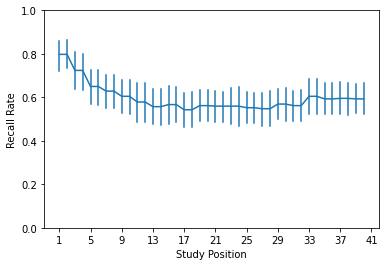

In [31]:
import matplotlib.pyplot as plt

plt.figure()
axis = plt.gca()
plot_flex_spc([events], 'condition == 2', axis=axis);

In [12]:
fast_mixed_spc(trials[list_types==1], presentations[list_types==1])

array([0.64285714, 0.56904762, 0.5047619 , 0.45238095, 0.40952381,
       0.38571429, 0.35      , 0.33571429, 0.33571429, 0.3       ,
       0.32380952, 0.32619048, 0.32619048, 0.32380952, 0.29761905,
       0.31190476, 0.32380952, 0.29761905, 0.27857143, 0.27142857,
       0.29047619, 0.28333333, 0.27857143, 0.32857143, 0.28095238,
       0.33095238, 0.32857143, 0.31666667, 0.32619048, 0.33809524,
       0.37380952, 0.32380952, 0.36190476, 0.34047619, 0.35952381,
       0.37619048, 0.39047619, 0.42380952, 0.41428571, 0.3452381 ])

In [13]:
flex_mixed_spc(trials[list_types==1], presentations[list_types==1])

array([0.64285714, 0.56904762, 0.5047619 , 0.45238095, 0.40952381,
       0.38571429, 0.35      , 0.33571429, 0.33571429, 0.3       ,
       0.32380952, 0.32619048, 0.32619048, 0.32380952, 0.29761905,
       0.31190476, 0.32380952, 0.29761905, 0.27857143, 0.27142857,
       0.29047619, 0.28333333, 0.27857143, 0.32857143, 0.28095238,
       0.33095238, 0.32857143, 0.31666667, 0.32619048, 0.33809524,
       0.37380952, 0.32380952, 0.36190476, 0.34047619, 0.35952381,
       0.37619048, 0.39047619, 0.42380952, 0.41428571, 0.3452381 ])

In [14]:
fast_mixed_spc(trials[list_types==3], presentations[list_types==3])

array([0.75714286, 0.70952381, 0.68809524, 0.66666667, 0.66428571,
       0.6952381 , 0.67380952, 0.67619048, 0.64761905, 0.64761905,
       0.63809524, 0.59761905, 0.62857143, 0.5952381 , 0.64285714,
       0.56904762, 0.6047619 , 0.59285714, 0.58571429, 0.6047619 ,
       0.55238095, 0.56904762, 0.57380952, 0.55238095, 0.61190476,
       0.56666667, 0.6047619 , 0.61190476, 0.62142857, 0.61666667,
       0.6452381 , 0.62380952, 0.61666667, 0.65714286, 0.66666667,
       0.68333333, 0.6952381 , 0.68571429, 0.67142857, 0.67857143])

In [15]:
fast_mixed_spc(trials[list_types==4], presentations[list_types==4])

array([0.63809524, 0.5452381 , 0.46666667, 0.43333333, 0.4547619 ,
       0.41666667, 0.42142857, 0.42619048, 0.40714286, 0.4       ,
       0.40714286, 0.43333333, 0.44285714, 0.43333333, 0.44285714,
       0.40238095, 0.40238095, 0.43809524, 0.41666667, 0.42857143,
       0.36190476, 0.38809524, 0.36904762, 0.38333333, 0.42142857,
       0.40714286, 0.42619048, 0.39761905, 0.42619048, 0.39285714,
       0.39285714, 0.41666667, 0.42142857, 0.44761905, 0.42619048,
       0.43095238, 0.40714286, 0.37142857, 0.38333333, 0.30952381])

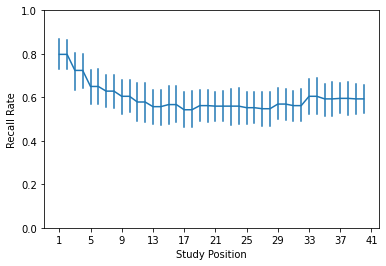

In [17]:
from compmemlearn.analyses import fast_spc

%timeit fast_spc(trials[list_types==1], list_length)

61 µs ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit fast_mixed_spc(trials[list_types==1], presentations[list_types==1])

1.22 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
%timeit flex_mixed_spc(trials[list_types==1], presentations[list_types==1])

4.27 ms ± 63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
